In [1]:
import os
import sys
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_columns', 500) 
pd.set_option('display.max_rows', 500) 


# 1.前処理

## 1-1 配布データのチェック

### 1-1-1.自転車の台数状況データ（status.csv）

平日と週末の通勤状況を考えば、利用可能な自転車数の差がある可能性は高い。検証のため、新たな特徴"weekday"を追加し、曜日ごとの時間平均利用可能な自転車数を集計した。集計結果によると、週末の方が平日よりやや大きく、自転車は通勤のため使われるかもしれません。

In [2]:
status = pd.read_csv('status.csv') 
status.head(2)

,id,year,month,day,hour,station_id,bikes_available,predict
0,0,2013,9,1,0,0,11.0,0
1,1,2013,9,1,1,0,11.0,0


In [3]:
status["date"] = pd.to_datetime(status[["year", "month", "day"]])

In [4]:
status["weekday"] = status["date"].dt.weekday
status["weekday"] = status["weekday"].replace({0:'Monday', 1:'Tuesday',2:'Wednesday',
                                              3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})

In [5]:
status_copy = status.copy()
status_copy = status_copy.loc[status_copy["predict"] == 0]
groupby = status_copy.groupby("weekday").agg({"bikes_available":"mean"}).reset_index()
groupby.columns = ["weekday","mean_bikes_available"]
groupby["weekday"] = pd.Categorical(groupby["weekday"], ["Monday","Tuesday","Wednesday",
                                                         "Thursday","Friday","Saturday","Sunday"] )
groupby = groupby.sort_values("weekday")
groupby

,weekday,mean_bikes_available
1,Monday,8.430464
5,Tuesday,8.403066
6,Wednesday,8.414945
4,Thursday,8.473303
0,Friday,8.524257
2,Saturday,8.581113
3,Sunday,8.535698


### 1-1-2.ステーション情報（station.csv）

station.csvとstatus.csvが同じく"station_id"特徴を持つことは分かった。  
"installation_date"のデータ型を日付型に変更しました。

In [6]:
station = pd.read_csv("station.csv")
station['installation_date'] = pd.to_datetime(station['installation_date'],format="%m/%d/%Y")
station.head(2)

,station_id,lat,long,dock_count,city,installation_date
0,0,37.32973,-121.90178,27,city1,2013-08-06
1,1,37.33070,-121.88898,15,city1,2013-08-05


### 1-1-3.気象情報（weather.csv）

欠損値が含む"event"特徴を直接に削除してもいいが、"event"の各要素（雨、霧など）を考えたら、"event"の欠損値が好天気を表すことは分かった。そのため、"event"特徴を保留し、ダミー変数に変更したほうがより妥当的かもしれない。

In [7]:
weather = pd.read_csv('weather.csv') 
weather['date'] = pd.to_datetime(weather['date'],format="%Y-%m-%d")
weather.head(2)

,date,max_temperature,mean_temperature,min_temperature,max_dew_point,mean_dew_point,min_dew_point,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure,mean_sea_level_pressure,min_sea_level_pressure,max_visibility,mean_visibility,min_visibility,max_wind_Speed,mean_wind_speed,precipitation,cloud_cover,events,wind_dir_degrees
0,2013-09-01,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.0,1,NaN,354
1,2013-09-02,80,71,66,64,61,58,80,70,58,29.95,29.95,29.86,10,10,10,14,4,0.0,5,NaN,337


In [8]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     730 non-null    datetime64[ns]
 1   max_temperature          730 non-null    int64         
 2   mean_temperature         730 non-null    int64         
 3   min_temperature          730 non-null    int64         
 4   max_dew_point            730 non-null    int64         
 5   mean_dew_point           730 non-null    int64         
 6   min_dew_point            730 non-null    int64         
 7   max_humidity             730 non-null    int64         
 8   mean_humidity            730 non-null    int64         
 9   min_humidity             730 non-null    int64         
 10  max_sea_level_pressure   730 non-null    float64       
 11  mean_sea_level_pressure  730 non-null    float64       
 12  min_sea_level_pressure   730 non-nul

In [9]:
weather["events"].value_counts(dropna=False)

NaN         636
Rain         82
Fog          10
Fog-Rain      2
Name: events, dtype: int64

In [10]:
weather = pd.get_dummies(weather, dummy_na=True) 

### 1-1-4.利用者の移動履歴データ(trip.csv)

力不足のため、"station_id"も"date"も持たなく、他のデータと合併できないtrip.csvを今回一応使わなかったです。

In [11]:
trip = pd.read_csv("trip.csv")
trip.head(2)

,trip_id,duration,start_date,start_station_id,end_date,end_station_id,bike_id,subscription_type
0,0,63,8/29/2013 14:13,54,8/29/2013 14:14,54,0,Subscriber
1,1,70,8/29/2013 14:42,8,8/29/2013 14:43,8,1,Subscriber


## 1-2.trainとtestの分割

status,station,weatherを合併し、trainとtestに分割した。  
trainについては、"bikes_available"特徴に欠損値があることを判明し、欠損レコードを削除した；  
testについては、"bikes_available"特徴以外に欠損値なしのことを判明しました。

In [12]:
_ = pd.merge(status, station, on = "station_id")
_ = pd.merge(_, weather, on = "date")

In [13]:
_ = pd.get_dummies(_, dummy_na=False) 
_.head(2)

,id,year,month,day,hour,station_id,bikes_available,predict,date,lat,long,dock_count,installation_date,max_temperature,mean_temperature,min_temperature,max_dew_point,mean_dew_point,min_dew_point,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure,mean_sea_level_pressure,min_sea_level_pressure,max_visibility,mean_visibility,min_visibility,max_wind_Speed,mean_wind_speed,precipitation,cloud_cover,wind_dir_degrees,events_Fog,events_Fog-Rain,events_Rain,events_nan,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,city_city1,city_city2,city_city3,city_city4,city_city5
0,0,2013,9,1,0,0,11.0,0,2013-09-01,37.32973,-121.90178,27,2013-08-06,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.0,1,354,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
1,1,2013,9,1,1,0,11.0,0,2013-09-01,37.32973,-121.90178,27,2013-08-06,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.0,1,354,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0


In [14]:
_.shape

(1226400, 49)

In [15]:
train = _.loc[_["predict"] == 0]

In [16]:
train.head(2)

,id,year,month,day,hour,station_id,bikes_available,predict,date,lat,long,dock_count,installation_date,max_temperature,mean_temperature,min_temperature,max_dew_point,mean_dew_point,min_dew_point,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure,mean_sea_level_pressure,min_sea_level_pressure,max_visibility,mean_visibility,min_visibility,max_wind_Speed,mean_wind_speed,precipitation,cloud_cover,wind_dir_degrees,events_Fog,events_Fog-Rain,events_Rain,events_nan,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,city_city1,city_city2,city_city3,city_city4,city_city5
0,0,2013,9,1,0,0,11.0,0,2013-09-01,37.32973,-121.90178,27,2013-08-06,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.0,1,354,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
1,1,2013,9,1,1,0,11.0,0,2013-09-01,37.32973,-121.90178,27,2013-08-06,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.0,1,354,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0


In [17]:
train.shape

(1033200, 49)

In [18]:
train.isna().any(axis=0)

id                         False
year                       False
month                      False
day                        False
hour                       False
station_id                 False
bikes_available             True
predict                    False
date                       False
lat                        False
long                       False
dock_count                 False
installation_date          False
max_temperature            False
mean_temperature           False
min_temperature            False
max_dew_point              False
mean_dew_point             False
min_dew_point              False
max_humidity               False
mean_humidity              False
min_humidity               False
max_sea_level_pressure     False
mean_sea_level_pressure    False
min_sea_level_pressure     False
max_visibility             False
mean_visibility            False
min_visibility             False
max_wind_Speed             False
mean_wind_speed            False
precipitat

In [19]:
train = train.dropna(subset = ["bikes_available"])

In [20]:
test = _.loc[_["predict"] == 1]

In [21]:
test.shape

(193200, 49)

In [22]:
test.head(2)

,id,year,month,day,hour,station_id,bikes_available,predict,date,lat,long,dock_count,installation_date,max_temperature,mean_temperature,min_temperature,max_dew_point,mean_dew_point,min_dew_point,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure,mean_sea_level_pressure,min_sea_level_pressure,max_visibility,mean_visibility,min_visibility,max_wind_Speed,mean_wind_speed,precipitation,cloud_cover,wind_dir_degrees,events_Fog,events_Fog-Rain,events_Rain,events_nan,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,city_city1,city_city2,city_city3,city_city4,city_city5
613201,8761,2014,9,1,1,0,NaN,1,2014-09-01,37.32973,-121.90178,27,2013-08-06,85,73,60,60,58,53,84,59,34,29.87,29.83,29.77,10,10,10,17,5,0.0,0,342,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
613202,8762,2014,9,1,2,0,NaN,1,2014-09-01,37.32973,-121.90178,27,2013-08-06,85,73,60,60,58,53,84,59,34,29.87,29.83,29.77,10,10,10,17,5,0.0,0,342,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0


In [23]:
test.isna().any(axis=0)

id                         False
year                       False
month                      False
day                        False
hour                       False
station_id                 False
bikes_available             True
predict                    False
date                       False
lat                        False
long                       False
dock_count                 False
installation_date          False
max_temperature            False
mean_temperature           False
min_temperature            False
max_dew_point              False
mean_dew_point             False
min_dew_point              False
max_humidity               False
mean_humidity              False
min_humidity               False
max_sea_level_pressure     False
mean_sea_level_pressure    False
min_sea_level_pressure     False
max_visibility             False
mean_visibility            False
min_visibility             False
max_wind_Speed             False
mean_wind_speed            False
precipitat

In [24]:
test["bikes_available"].value_counts(dropna=False)

NaN    193200
Name: bikes_available, dtype: int64

## 1-3.trainとtestの年月分布のチェック

データリークの発生を防ぐため、trainとtestそれぞれの年月分布のチェックは必要だ。

"yearmonth"特徴を追加しかつ"yearmonth"特徴を可視化したら、それについてのチェックが便利。 

In [25]:
def add_yearmonth(df):
    df1 = df[df['month'] < 10].copy()
    df2 = df[df['month'] >= 10].copy()
    df1['yearmonth'] = df1['year'].astype(str) + ('0' + df1['month'].astype(str))
    df2['yearmonth'] = df2['year'].astype(str) + df2['month'].astype(str)
    return pd.concat([df1, df2])

train = add_yearmonth(train)
test = add_yearmonth(test)

In [26]:
def check_yearmonth(df):
    groupby = df.groupby("yearmonth").apply(lambda x: len(x)).reset_index()
    groupby.columns = ["yearmonth","size"]
    groupby = groupby.sort_values("yearmonth", ascending = True)
    return groupby

In [27]:
check_yearmonth(train)

,yearmonth,size
0,201309,46080
1,201310,47616
2,201311,46080
3,201312,47664
4,201401,50083
5,201402,45900
6,201403,51336
7,201404,50196
8,201405,52080
9,201406,50400


In [28]:
check_yearmonth(test)

,yearmonth,size
0,201409,16100
1,201410,16100
2,201411,16100
3,201412,16100
4,201501,16100
5,201502,16100
6,201503,16100
7,201504,16100
8,201505,16100
9,201506,16100


<AxesSubplot:ylabel=' '>

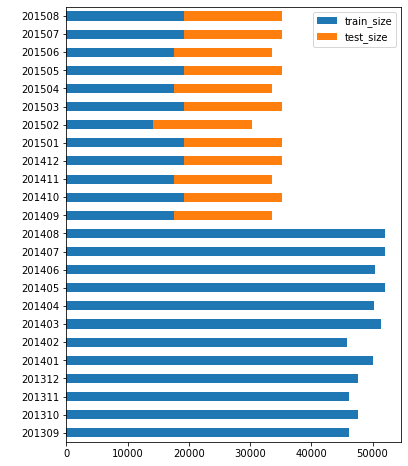

In [29]:
train_groupby, test_groupby = check_yearmonth(train), check_yearmonth(test)
df = pd.merge(train_groupby,test_groupby,on="yearmonth",how="outer")
df = df.fillna(0)
df.columns = ["yearmonth", "train_size", "test_size"]
df.plot.barh(x="yearmonth",
             xlabel= " ",ylabel="", 
             figsize=(6,8), stacked=True)

# 2.関数の定義

## 2-1.訓練関数

validationについては、sylkさんの方法を参考しました。  
2014年9月testを予測する場合、2014年8月のtrainデータで検証、2014年7月以前のtrainデータで訓練；2014年10月testを予測する場合、2014年9月のtrainデータで検証、2014年8月以前のtrainデータで訓練...このように繰り返します。(Slide Window)     　

In [30]:
import lightgbm as lgb

cv_score = []
def Train(train,year_month):
    train = train.drop(["date", "id", "predict", "installation_date"], axis=1)
    
    if year_month == "201501":
        valid_split = train.loc[train["yearmonth"] == "201412"]
        train_split = train.loc[train["yearmonth"] < "201412"]
    else:
        valid_split = train.loc[train["yearmonth"] == str(int(year_month) - 1)]
        train_split = train.loc[train["yearmonth"] < str(int(year_month) - 1)]

    # training
    X_train, X_test=train_split.drop(["yearmonth", "bikes_available"], axis=1), valid_split.drop(["yearmonth", "bikes_available"], axis=1)
    Y_train, Y_test=train_split['bikes_available'], valid_split['bikes_available']
    
    lgb_train=lgb.Dataset(X_train,Y_train)
    lgb_eval=lgb.Dataset(X_test,Y_test)
    params={
        'boosting': 'gbdt',
        'objective':'regression',
        'metric':'rmse',
        'learning_rate':0.01,
        'num_leaves': 191,         
        'seed': 42,}

    evals_result = {}
    early_stopping_rounds = 100
    model=lgb.train(params, lgb_train, 
                valid_names = ["train", "valid"],
                valid_sets=[lgb_train,lgb_eval],
                evals_result=evals_result, #dict{}でmetricを保存
                verbose_eval=500,  
                num_boost_round=3000, 
                early_stopping_rounds=early_stopping_rounds,
               )
    
    global cv_score
    if early_stopping_rounds == 0:
        cv_score.append(evals_result["valid"]["rmse"][-1])
    else:
        cv_score.append(evals_result["valid"]["rmse"][model.best_iteration - 1])

    
    return  evals_result, model, cv_score

## 2-2.予測関数

test_idで元test_splitの"id"を保存し、lightgbm.predictで预测。  

In [31]:
def Predict(test, year_month, model_best_iteration):
    test_split = test.loc[test["yearmonth"] == year_month]
    
    test_id = pd.DataFrame(test_split["id"])
    test_id = test_id.reset_index()
    del test_id["index"]
    
    test_feature = test_split.drop(["id", "predict", "bikes_available", "yearmonth", "date", "installation_date"], axis=1)
    test_label = model.predict(test_feature, num_iteration=model.best_iteration)
    test_label = pd.DataFrame(test_label)
    
    test_label = pd.concat([test_id, test_label], axis=1)
    return test_label

## 2-3.ツール関数

ツール関数の定義

In [32]:
class Tool:
    def Get_YearMonth_List():
        _ = []
        for x in range(4):
            year_month = str(201409 + x)
            _.append(year_month)
        for x in range(1,9):
            year_month = str(201500 + x)
            _.append(year_month)
        return _

    def Print_YearMonth(year_month):
        if year_month == "201501":
            train_year_month, valid_year_month = "201411", "201412"
        elif year_month == "201502":
            train_year_month, valid_year_month = "201412", "201501"
        else:
            train_year_month, valid_year_month = str(int(year_month) - 2), str(int(year_month) - 1)
        test_year_month = year_month
        print("-----------------------------")
        print("Train: 201309 ～ " + train_year_month +" TrainSet" )
        print("Valid: " + valid_year_month + " TrainSet")
        print("Test:  " + test_year_month  + " TestSet")
        
    def Plot_Metric(evals_result,year_month):
        lgb.plot_metric(evals_result,title='YearMonth' + year_month +'_Metric during training',
          xlabel='Iterations', ylabel='auto', figsize=(7,4), grid=True)
    
    def Plot_Importance(model,year_month):
        lgb.plot_importance(model, height=0.5,max_num_features=20,title='YearMonth' + year_month +'_Feature Importance',
          xlabel='Feature importance', ylabel="",figsize=(5.5,4), grid=True)

    def Print_CV(cv_score):
        print("------------ " + " END" + " ------------") 
        cv_score = float(sum(cv_score))/len(cv_score) 
        print ("CV: ", cv_score) 

# 3.訓練及び予測

-----------------------------
Train: 201309 ～ 201407 TrainSet
Valid: 201408 TrainSet
Test:  201409 TestSet
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 539515, number of used features: 43
[LightGBM] [Info] Start training from score 8.601260
Training until validation scores don't improve for 100 rounds
[500]	train's rmse: 2.59446	valid's rmse: 3.173
Early stopping, best iteration is:
[514]	train's rmse: 2.58882	valid's rmse: 3.17273
 
-----------------------------
Train: 201309 ～ 201408 TrainSet
Valid: 201409 TrainSet
Test:  201410 TestSet
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [In

 
------------  END ------------
CV:  3.4237155800452643


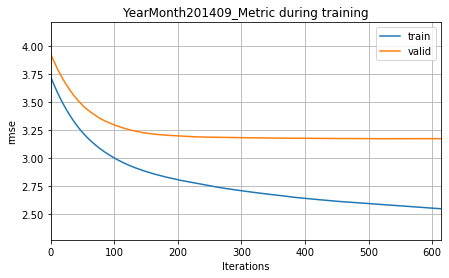

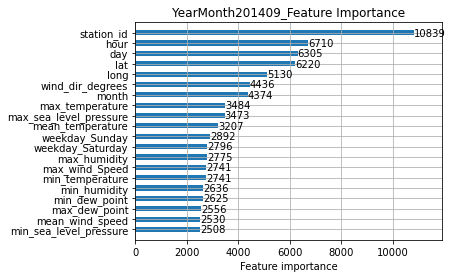

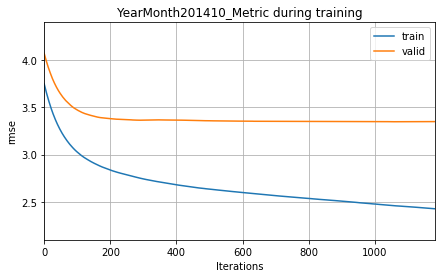

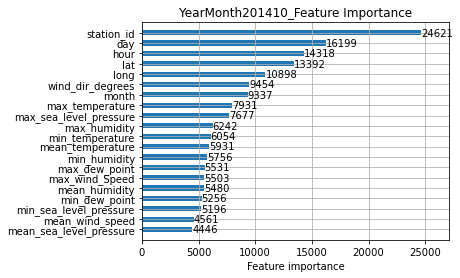

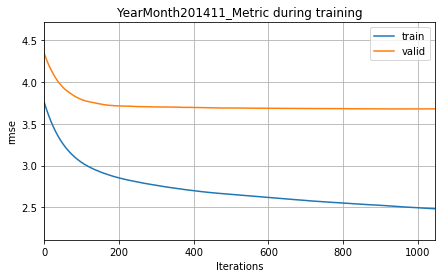

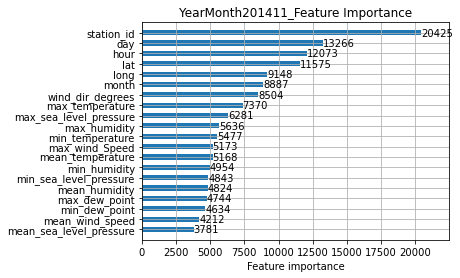

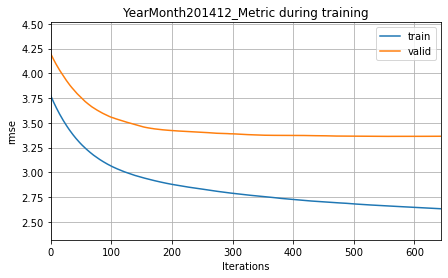

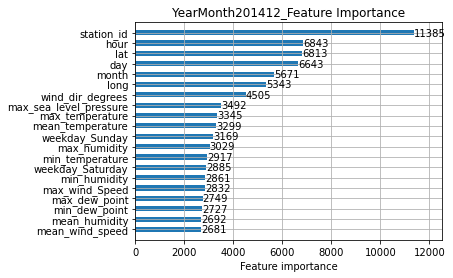

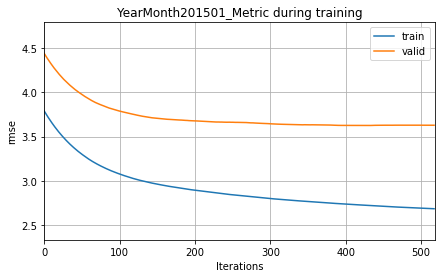

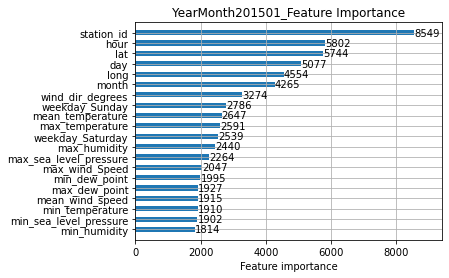

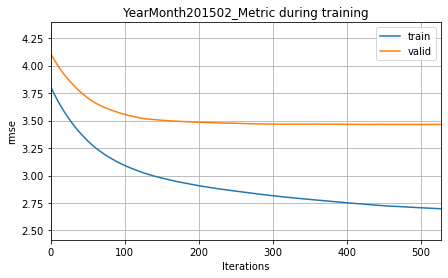

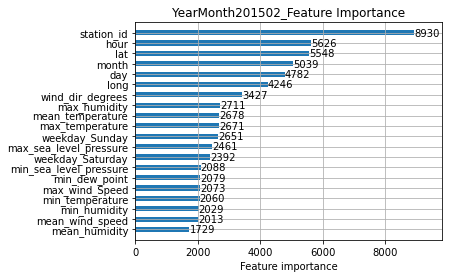

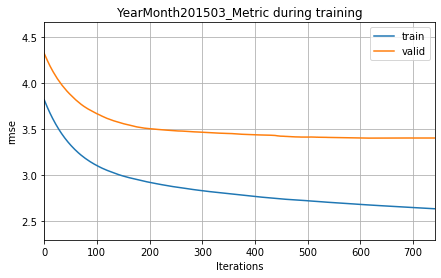

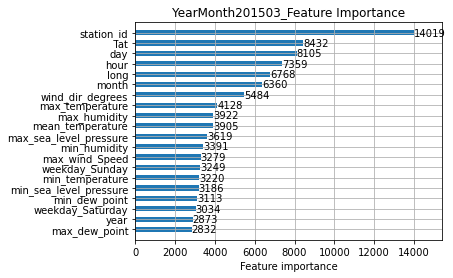

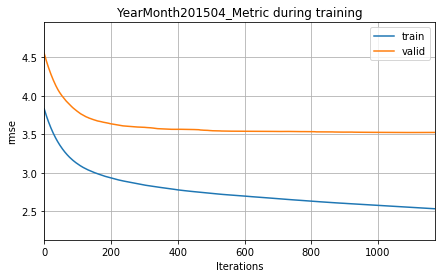

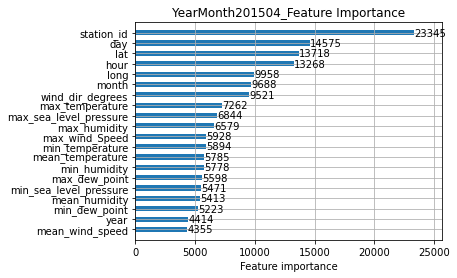

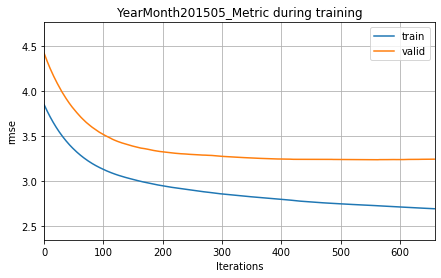

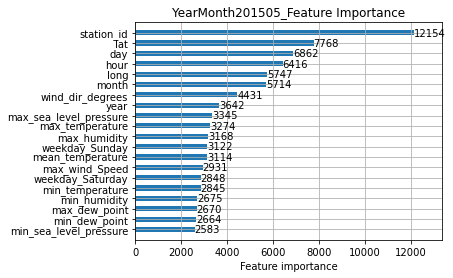

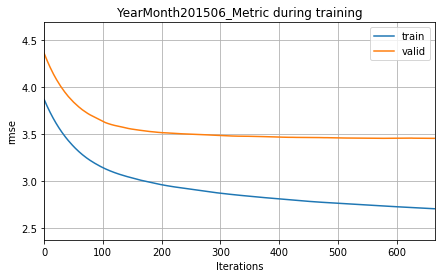

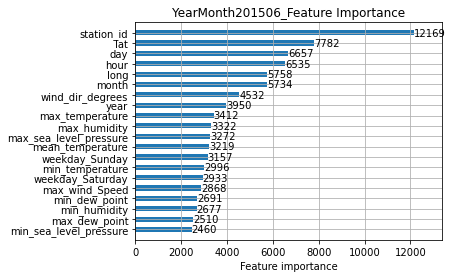

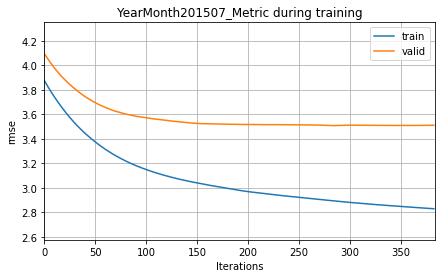

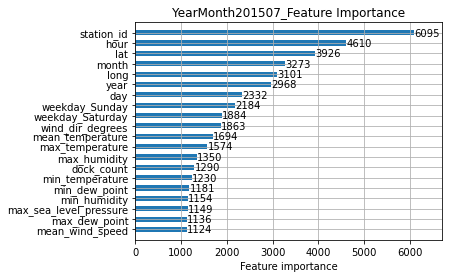

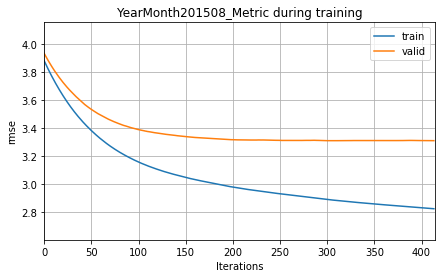

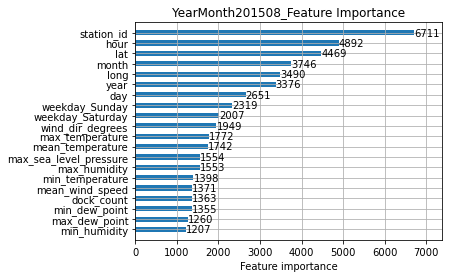

In [33]:
test_labels = pd.DataFrame([])

yearmonth_list = Tool.Get_YearMonth_List()
while yearmonth_list != []:
    year_month = yearmonth_list.pop(0)
    Tool.Print_YearMonth(year_month)
    
    evals_result, model, cv_score = Train(train, year_month)
    
    Tool.Plot_Metric(evals_result,year_month)
    Tool.Plot_Importance(model,year_month)
    
    test_label = Predict(test, year_month, model.best_iteration)
    test_labels = pd.concat([test_labels, test_label])
    print(" ")
    
Tool.Print_CV(cv_score)

# 4.出力

In [34]:
test_labels.columns = ["id", "pred"]
submission = pd.DataFrame(test_labels)
submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193200 entries, 0 to 16099
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      193200 non-null  int64  
 1   pred    193200 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 4.4 MB


In [35]:
submission.to_csv("submission.csv",index=False, header=False)